In [4]:
pwd

'/Users/edwardterrell/Desktop/Training/kindle/strava'

In [5]:
import requests
import json
import time
import os
from pprint import pprint
from datetime import date,timedelta,datetime

import pandas as pd
pd.set_option('display.precision', 1)
import warnings
warnings.filterwarnings("ignore", message=".*will drop timezone.*")

%load_ext autoreload
%autoreload 2
from clean_convert import cleanup, convert_speed, order_columns, process_new_data, save_data, get_date, get_year
from zones import get_zones_for_id, build_week_summary
from plots_details import display_detail_week

# import graphics programs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,6)}) # for all future plots

import sys
sys.executable

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/edwardterrell/opt/anaconda3/envs/mlml/bin/python'

In [12]:
%matplotlib inline
from IPython.core.display import HTML
css = open('css/style-table.css').read() + open('css/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
from token_manager import get_valid_access_token
import requests

access_token = get_valid_access_token()
print("Using access token:", access_token)

# Make an authenticated API call
response = requests.get(
    'https://www.strava.com/api/v3/athlete',
    headers={'Authorization': f'Bearer {access_token}'}
)
print(response.json())

Using access token: 125cc6e6f3f0700ad443f367d90a3965931b9422
{'id': 723727, 'username': 'eterrell', 'resource_state': 2, 'firstname': 'Ed', 'lastname': 'Terrell', 'bio': '', 'city': 'Boulder', 'state': 'CO', 'country': 'United States', 'sex': 'M', 'premium': True, 'summit': True, 'created_at': '2012-07-05T00:04:09Z', 'updated_at': '2025-07-09T12:38:59Z', 'badge_type_id': 1, 'weight': 61.235, 'profile_medium': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/medium.jpg', 'profile': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/large.jpg', 'friend': None, 'follower': None}


### Load dataframes

In [8]:
# Loading empty dfs for user to start from scratch
strava_df = pd.read_pickle(f"data/strava_data_empty.pkl")
strava_zone_df = pd.read_pickle(f"data/strava_zone_data_empty.pkl")
!tree data

data
├── 2025-07-17
│   ├── strava_data_2025.pkl
│   └── strava_zone_data_2025.pkl
├── 2025-07-18
│   ├── strava_data_2024.pkl
│   └── strava_zone_data_2024.pkl
├── 2025-07-19
│   ├── strava_data_2025.pkl
│   └── strava_zone_data_2025.pkl
├── 2025-07-20
│   ├── strava_data_2025.pkl
│   └── strava_zone_data_2025.pkl
├── 2025-07-22
│   ├── strava_data_2025.pkl
│   └── strava_zone_data_2025.pkl
├── 2025-07-23
│   ├── strava_data_2025.pkl
│   └── strava_zone_data_2025.pkl
├── 2025-07-24
│   ├── strava_data_2025.pkl
│   └── strava_zone_data_2025.pkl
├── 2025-07-26
│   ├── strava_data_2025.pkl
│   └── strava_zone_data_2025.pkl
├── strava_data_2024.pkl
├── strava_data_2025.pkl
├── strava_data_empty.pkl
├── strava_zone_data_2024.pkl
├── strava_zone_data_2025.pkl
└── strava_zone_data_empty.pkl

9 directories, 22 files


### Select date range and year

In [9]:
# select 'empty' to start new dfs from scratch
# Default values
today = date.today().strftime('%Y-%m-%d')
yesterday = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')
tomorrow = (date.today() + timedelta(days=1)).strftime('%Y-%m-%d')

# Get folder name and year from user
my_folder = get_date("Enter folder date", default=yesterday)
print(f"✅ Folder selected: {my_folder}")
if my_folder is None:
    print("📭 Empty data mode selected. Skipping further input.")
else:
    # Get year from user
    year = get_year("Enter year", default='2025')
    print(f"✅ Year selected: {year}")
    # Reload dfs and confirm lengths
    strava_df = pd.read_pickle(f"data/{my_folder}/strava_data_{year}.pkl")
    strava_zone_df = pd.read_pickle(f"data/{my_folder}/strava_zone_data_{year}.pkl")

Enter folder date [2025-07-26]:  


✅ Folder selected: 2025-07-26


Enter year [2025]:  


✅ Year selected: 2025


In [10]:
# confirm lengths and assign starting length to length_df for later comparision
length_df = len(strava_df)
print (f'There are {len(strava_df)} activities in strava_df.')
print (f'There are {len(strava_zone_df)} activities in strava_zone_df.')

129
129


In [11]:
strava_df.head(1)
strava_zone_df.head(1)

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score,time-minutes,average_speed,start_date
0,15244794134,Ward - feeling good,2025-07-26,Ride,50.2,4:01,12.5,4488.2,117.8,150.0,123.0,241.2,5.6,2025-07-26 12:54:23+00:00


,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,HR-value,weekly_intense,weekly_moderate,weekly_suffer_score,weekly_HR-value
0,15244794134,Ward - feeling good,2025-07-26,123.0,2025-07-26 12:54:23+00:00,33.4,73.8,104.1,29.4,0.6,107.2,134.0,2025-07-21,187.6,211.1,428.1,260.0,425.2


### Update a specific activity

### Recent activities only!

In [13]:
# Get start and end dates from user
start_date_str = get_date("Enter START date", default=yesterday)
end_date_str = get_date("Enter END date", default=tomorrow)

print(f"\n✅ Date range selected:\nStart: {start_date_str}\nEnd:   {end_date_str}")


Enter START date [2025-07-26]:  
Enter END date [2025-07-28]:  



✅ Date range selected:
Start: 2025-07-26
End:   2025-07-28


In [14]:
# Desired number of activities for upload
num_of_activities_for_upload = 50 #select maximum desired

# change date to unix integer format with mktime
start_date = int(time.mktime(time.strptime(start_date_str, '%Y-%m-%d')))
end_date = int(time.mktime(time.strptime(end_date_str, '%Y-%m-%d')))
print()

# strava url
url = "https://www.strava.com/api/v3/athlete/activities"
headers = {"Authorization": f"Bearer {access_token}"}
params = {
    "before": end_date,
    "after": start_date,
    "per_page": 200,  # max per request
    "page": 1
}
activities = []

stop_fetching = False
while True:
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    if not data or stop_fetching:
        # breaks out of while loop
        break
        
    for activity in data:
        # change date to unix integer format
        activity_date = int(datetime.strptime(activity['start_date'], "%Y-%m-%dT%H:%M:%SZ").timestamp())
        print(f"ID: {activity['id']}, Name: {activity['name']}, Date: {activity['start_date']}")
        # set number of activites (strava maximum is 100/15 minutes)
        if len(activities) >= num_of_activities_for_upload:
            stop_fetching = True
            # breaks out of for loop only
            break
        activities.append(activity)
    params["page"] += 1


ID: 15255996830, Name: Gold Hill via Gold Run, Date: 2025-07-27T13:40:08Z
ID: 15244794134, Name: Ward - feeling good, Date: 2025-07-26T12:54:23Z


In [15]:
# Build out strava_df with only the necessary columns
recent_df = pd.DataFrame(activities)
cols_needed = ['id','name', 'distance', 'moving_time','total_elevation_gain', 'sport_type',
          'average_speed', 'average_heartrate','max_heartrate', 'suffer_score','start_date']
recent_df = recent_df.loc[:,cols_needed]
recent_df = recent_df.sort_values('start_date',ascending=False) 

# This step does the comparison between recent_df and strava_df
# strava_df holds previously saved data

if strava_df.empty:
    new_activities_df = recent_df.copy()
else:
    new_activities_df = recent_df[~recent_df.id.isin(strava_df.id)].copy()
    
# display df of new activities
print()
print(f'You have {len(new_activities_df)} activity to process')


You have 1 activity to process


In [16]:
strava_df = process_new_data(new_activities_df, strava_df)

print (f'You haved processed {len(strava_df)- length_df} activity. There are now {len(strava_df)} activities in strava_df.')


You haved processed 1 activity. There are now 130 activities in strava_df.


### Get Zone data

In [17]:
# Recent zone data
# Create a new_zone dataframe for recent activities
cols = ['id', 'name', 'date', 'suffer_score','start_date']
new_data = strava_df.loc[:,cols]
new_zone_df = pd.DataFrame(new_data, columns=cols)

mask = new_zone_df['id'].isin(new_activities_df['id'])
new_zone_df = new_zone_df[mask]

In [18]:
new_zone_df

,id,name,date,suffer_score,start_date
0,15255996830,Gold Hill via Gold Run,2025-07-27,82.0,2025-07-27 13:40:08+00:00


In [19]:
# get_zones_for_id is a function in zones.py
# There is a max limit of 100 calls per 15 minutes set by Strava for this function
    
if len(new_zone_df) > 0 and len(new_zone_df) < 100:
    print (len(new_zone_df))
    # Apply function to fetch zone data per activity ID
    zone = new_zone_df['id'].apply(lambda current_id: get_zones_for_id(current_id, access_token))
    zone.index = new_zone_df['id']

    # display new zone info
    print()
    zone

elif  len(new_zone_df)==0:
    print ("No new activites to process")
    
elif len(new_zone_df) >= 100:
     print("❌ Number of calls will exceed Strava's 15-minute limit (max 100)")
     print ("Try limiting the number of calls before proceeding")

1
Fetching zones for activity: 15255996830



,Zone1,Zone2,Zone3,Zone4,Zone5
id,,,,,
15255996830,49.4,80.7,68.6,12.7,0.0


In [31]:
if len(new_zone_df) > 0 and len(new_zone_df) < 100:
    new_zone_df = pd.merge(new_zone_df, zone, left_on='id',right_index=True)

    # Get the Sunday start of the week for each date (time set to Sunday at midnight)
    new_zone_df['week_start'] = new_zone_df['start_date'].dt.to_period('W-SUN').dt.start_time
    
    #new_zone_df.columns are now matched with strava_zone_df
    new_zone_df = pd.concat ([new_zone_df, strava_zone_df], axis=0)
    
    len(strava_zone_df)
    len(new_zone_df)
    
    # Correct instance of faulty heart rate data; adds erroneous zone5 time to zone2
    mask = new_zone_df['Zone5'] > 5
    new_zone_df.loc[mask, 'Zone2'] = new_zone_df.loc[mask, 'Zone2'] + new_zone_df.loc[mask, 'Zone5']
    new_zone_df.loc[new_zone_df.suffer_score < 100, 'Zone5'] = 0
    
    # Add in summary zones: moderate and intense
    new_zone_df['moderate'] = new_zone_df[['Zone1', 'Zone2']].sum(axis=1)
    new_zone_df['intense'] = new_zone_df[['Zone3', 'Zone4', 'Zone5']].sum(axis=1)
    
    new_zone_df['HR-value'] = (new_zone_df.Zone2*0.5)+(new_zone_df.intense)

    # This drops all weekly_ cols since they are all recalculated later
    only_cols = ['id', 'name', 'date', 'suffer_score', 'start_date', 'Zone1', 'Zone2',
           'Zone3', 'Zone4', 'Zone5', 'moderate', 'intense', 'week_start','HR-value']
    new_zone_df = new_zone_df[only_cols]
    
    
    # Temporarily sort ascending by week_start and date to compute cumulative sum correctly
    temp = new_zone_df.sort_values(['week_start', 'start_date'])

    # Calculate cumulative sum within each week for weekly_ cols
    cumulative_cols = ['intense', 'moderate', 'suffer_score','HR-value']
    cumulative_sums = (
    temp
        .groupby('week_start')[cumulative_cols]
        .cumsum()
        .add_prefix('weekly_')  # rename columns if needed
    )
    # Add start_date column for reference
    cumulative_sums['start_date'] = temp['start_date']
    cumulative_sums = cumulative_sums.sort_values('start_date', ascending = False)
    cumulative_sums.head(3)
    strava_zone_df = pd.merge(new_zone_df,cumulative_sums, left_on ='start_date', right_on='start_date')

In [32]:
strava_zone_df.head()

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,HR-value,weekly_intense,weekly_moderate,weekly_suffer_score,weekly_HR-value
0,15255996830,Gold Hill via Gold Run,2025-07-27,82.0,2025-07-27 13:40:08+00:00,49.4,80.7,68.6,12.7,0.0,130.1,81.3,2025-07-21,129.7,292.4,558.3,342.0,523.2
1,15244794134,Ward - feeling good,2025-07-26,123.0,2025-07-26 12:54:23+00:00,33.4,73.8,104.1,29.4,0.6,107.2,134.0,2025-07-21,178.3,211.1,428.1,260.0,393.5
2,15216674933,Pedals and Pints,2025-07-23,18.0,2025-07-23 22:13:57+00:00,56.9,40.6,3.1,0.0,0.0,97.5,3.1,2025-07-21,27.4,77.1,320.9,137.0,215.2
3,15210498851,Old Stage and gravel loop,2025-07-23,51.0,2025-07-23 12:59:53+00:00,4.8,79.6,17.3,1.6,0.0,84.4,18.9,2025-07-21,66.7,74.0,223.5,119.0,187.7
4,15189628842,Poorman and Chapman,2025-07-21,68.0,2025-07-21 15:04:13+00:00,29.1,110.0,35.3,19.8,0.0,139.0,55.1,2025-07-21,121.1,55.1,139.0,68.0,121.1


### Plotting Section

In [33]:
# Reccomended weekly maximum of 540 minutes
week_summary = build_week_summary(strava_zone_df)
week_summary.sort_values('week_start',ascending=False).head()

,week_start,weekly_intense,weekly_moderate,weekly_suffer_score,weekly_HR-value,week
28,2025-07-21,292.4,558.3,342.0,523.2,Jul 21
27,2025-07-14,122.0,704.2,538.0,529.4,Jul 14
26,2025-07-07,152.0,767.9,546.0,563.6,Jul 07
25,2025-06-30,143.9,794.7,597.0,589.6,Jun 30
24,2025-06-23,259.7,479.1,662.0,514.1,Jun 23


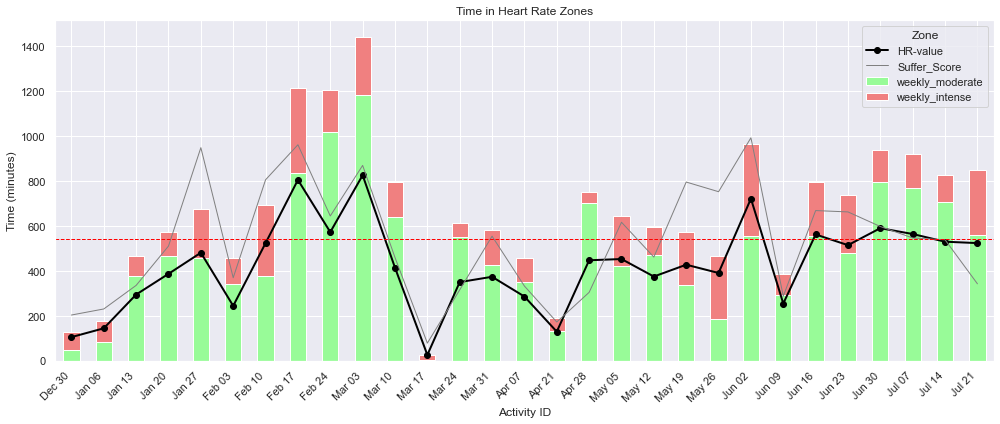

In [34]:
ax = week_summary.plot(
    y=['weekly_moderate','weekly_intense'],
    x='week',
    kind='bar', 
    stacked=True, 
    figsize=(14, 6), 
    color=['#98FB98', '#F08080']
)

# Overlay line plot for 'weekly_suffer_score'
line = ax.plot(
    week_summary["week"],
    week_summary["weekly_HR-value"],
    color="black",
    marker="o",
    linewidth=2,
    label="HR-value"  
)

# Overlay line plot for 'weekly_suffer_score'
line2 = ax.plot(
    week_summary["week"],
    week_summary["weekly_suffer_score"],
    color="grey",
    marker=None,
    linewidth=1,
    label="Suffer_Score"  
)

plt.axhline(y=540, color='red', linestyle='--', linewidth=1)

plt.title("Time in Heart Rate Zones");
plt.xlabel("Activity ID");
plt.ylabel("Time (minutes)");
plt.legend(title="Zone");
plt.xticks(rotation=45, ha='right');
plt.tight_layout();
plt.show();

### Drilling down a specific week

In [28]:
# default start is current week
start = week_summary.sort_values('week_start',ascending=False).iloc[0,0]
#start = "2025-06-02" # <-- select custom week starting date

In [29]:
week_df, zone_week_df = display_detail_week(start, strava_df, strava_zone_df)

In [30]:
week_df.sort_values('start_date',ascending=False)[['id','name', 'date', 'sport', 'distance', 'time', 'speed', 'elev_gain',
       'avg_HR', 'max_HR', 'suffer_score']]
zone_week_df.sort_values('start_date',ascending=False)[['name','date','Zone1', 'Zone2',
       'Zone3', 'Zone4', 'Zone5', 'moderate', 'intense','HR-value','suffer_score','week_start','weekly_moderate',
       'weekly_intense','weekly_HR-value']]

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score
0,15255996830,Gold Hill via Gold Run,2025-07-27,Ride,41.0,3:31,11.6,3424.5,112.4,140.0,82.0
0,15244794134,Ward - feeling good,2025-07-26,Ride,50.2,4:01,12.5,4488.2,117.8,150.0,123.0
0,15216674933,Pedals and Pints,2025-07-23,Ride,18.7,1:40,11.2,751.3,102.2,138.0,18.0
1,15210498851,Old Stage and gravel loop,2025-07-23,Ride,23.3,1:43,13.5,1389.4,130.9,202.0,51.0
0,15189628842,Poorman and Chapman,2025-07-21,Ride,35.5,3:14,11.0,2814.6,117.3,144.0,68.0


,name,date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,HR-value,suffer_score,week_start,weekly_moderate,weekly_intense,weekly_HR-value
0,Gold Hill via Gold Run,2025-07-27,49.4,80.7,68.6,12.7,0.0,130.1,81.3,129.7,82.0,2025-07-21,558.3,292.4,523.2
1,Ward - feeling good,2025-07-26,33.4,73.8,104.1,29.4,0.6,107.2,134.0,178.3,123.0,2025-07-21,428.1,211.1,393.5
2,Pedals and Pints,2025-07-23,56.9,40.6,3.1,0.0,0.0,97.5,3.1,27.4,18.0,2025-07-21,320.9,77.1,215.2
3,Old Stage and gravel loop,2025-07-23,4.8,79.6,17.3,1.6,0.0,84.4,18.9,66.7,51.0,2025-07-21,223.5,74.0,187.7
4,Poorman and Chapman,2025-07-21,29.1,110.0,35.3,19.8,0.0,139.0,55.1,121.1,68.0,2025-07-21,139.0,55.1,121.1


### Saving data

In [35]:
strava_df = strava_df.sort_values('id',ascending=False)
strava_zone_df = strava_zone_df.sort_values('id',ascending=False)

In [36]:
# verify before saving
strava_df.head(1)
strava_zone_df.head(1)
print(len(strava_df))
print(len(strava_zone_df))

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score,time-minutes,average_speed,start_date
0,15255996830,Gold Hill via Gold Run,2025-07-27,Ride,41.0,3:31,11.6,3424.5,112.4,140.0,82.0,211.4,5.2,2025-07-27 13:40:08+00:00


,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,HR-value,weekly_intense,weekly_moderate,weekly_suffer_score,weekly_HR-value
0,15255996830,Gold Hill via Gold Run,2025-07-27,82.0,2025-07-27 13:40:08+00:00,49.4,80.7,68.6,12.7,0.0,130.1,81.3,2025-07-21,129.7,292.4,558.3,342.0,523.2


130
130


### Use save_data, and year

In [37]:
# Select year for saving
# Data will be saved to: data/{today}
save_data(strava_df, strava_zone_df, 2025)

Data saved in folder: data/2025-07-27


### Other info

In [ ]:
# Set number of rows to display
pd.set_option('display.max_rows', 40)  # if set to None this will show all rows
pd.set_option('display.min_rows', 40)  # adjust to help override auto-truncation

strava_zone_df[['name','date','moderate','intense','HR-value','suffer_score']]
pd.reset_option('display.max_rows')